In [1]:
from experimental.remesh.dataset import BubbleDataset
from experimental.remesh.sequence_dataset import BubbleSequence

from experimental.remesh.bubble import rotation_matrix_to_y_axis

import matplotlib.pyplot as plt


from loky import get_reusable_executor


%load_ext memory_profiler
import numpy as np

import tracemalloc

import loky

In [2]:
%memit

dataset = BubbleSequence('./bubble-data', 1, center_prediction=True)


peak memory: 373.37 MiB, increment: 0.00 MiB


In [142]:
import numpy as np

def rotation_matrix_to_y_axis(vector):
    # # Normalize the input vector
    # vector = vector / np.linalg.norm(vector[:2])

    # # Compute the angle between the vector and the positive diagonal line (x=y)
    # angle = np.arctan2(vector[1], vector[0]) - np.pi/4

    # # Create the rotation matrix
    # rotation_matrix = np.array([[np.cos(angle), -np.sin(angle), 0],
    #                             [np.sin(angle), np.cos(angle), 0],
    #                             [0, 0, 1]])

    # return rotation_matrix
    # Normalize the input vector
    vector = vector / np.linalg.norm(vector[:2])

    # Compute the angle between the vector and the diagonal line (y = x)
    angle = np.arctan2(vector[1], vector[0])

    if vector[0] < 0:
        angle += np.pi

    # Create the rotation matrix
    rotation_matrix = np.array([[np.cos(angle), -np.sin(angle), 0],
                                [np.sin(angle), np.cos(angle), 0],
                                [0, 0, 1]])

    return rotation_matrix

# Example usage
vector = np.array([-5, 12, 1])  # Example vector
rotation_matrix = rotation_matrix_to_y_axis(vector)
print(rotation_matrix.dot(vector))

[9.15384615 9.23076923 1.        ]


In [2]:

# def rotation_matrix_to_y_axis(vector):
#     # Normalize the input vector
#     vector = vector / np.linalg.norm(vector[:2])

#     # Compute the angle between the vector and the positive diagonal line (x=y)
#     angle = np.arctan2(vector[1], vector[0]) - np.pi/4

#     # Create the rotation matrix
#     rotation_matrix = np.array([[np.cos(angle), -np.sin(angle), 0],
#                                 [np.sin(angle), np.cos(angle), 0],
#                                 [0, 0, 1]])

#     return rotation_matrix

def rotation_matrix_to_y_axis(vector):
    # Normalize the input vector
    vector = vector / np.linalg.norm(vector[:2])
    
    # Compute the angle between the vector and the y-axis
    angle = np.arccos(np.dot(vector[:2], np.array([0, 1])))

    if vector[0] < 0:
        angle = -angle

    # Create the rotation matrix
    rotation_matrix = np.array([[np.cos(angle), -np.sin(angle), 0],
                                [np.sin(angle), np.cos(angle), 0],
                                [0,0,1]])

    return rotation_matrix


def rotation_matrix_to_positive_diagonal(vector):
    # Normalize the input vector
    vector = vector / np.linalg.norm(vector[:2])
    
    # Compute the angle between the vector and the y-axis
    angle = np.arccos(np.dot(vector[:2], np.array([0, 1])))

    if vector[0] < 0:
        angle = -angle

    # Create the rotation matrix
    rotation_matrix = np.array([[np.cos(angle), -np.sin(angle), 0],
                                [np.sin(angle), np.cos(angle), 0],
                                [0,0,1]])
    
    angle2 = -np.pi/4
    angle_matrix = np.array([[np.cos(angle2), -np.sin(angle2), 0],
                                [np.sin(angle2), np.cos(angle2), 0],
                                [0,0,1]])
    return rotation_matrix



vector = np.array([1, 3, 1])  # Example vector

rotation_matrix = rotation_matrix_to_positive_diagonal(vector)
# vector = np.array([3, 4, 2])  # Example vector

# rotation_matrix = rotation_matrix_to_x_equals_y(vector)
print(rotation_matrix)

print(rotation_matrix.dot(vector))

[[ 0.9486833  -0.31622777  0.        ]
 [ 0.31622777  0.9486833   0.        ]
 [ 0.          0.          1.        ]]
[-4.44089210e-16  3.16227766e+00  1.00000000e+00]


(-10.0, 10.0)

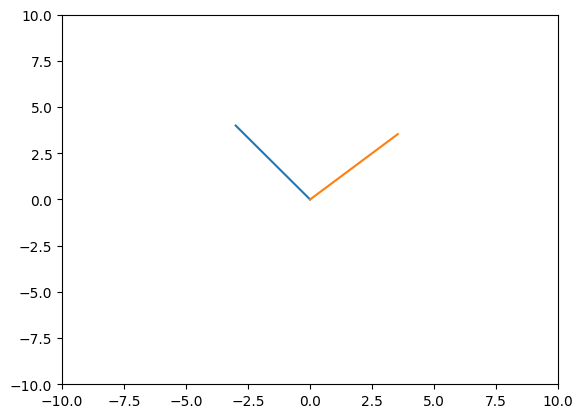

In [3]:
plt.plot([0, -3], [0, 4])

plt.plot([0, 3.53553391 ], [0, 3.53553391])

plt.xlim(-10, 10)
plt.ylim(-10, 10)

In [40]:
%memit

def rotate_by_step(prev_vec, current_vec):
    rotation_matrix = rotation_matrix_to_y_axis(prev_vec)

    return current_vec@rotation_matrix.T

def get_bubble_info(bubble_sequence):
    

    positions = np.array([bubble.centroid(True).numpy() for bubble in bubble_sequence])

    velocities = np.array([bubble.center_velocity for bubble in bubble_sequence])
    targets = np.array([bubble.center_target for bubble in bubble_sequence])

    bubble_velocities = np.array([(bubble - positions[i-1]) for i, bubble in enumerate(positions) if i > 0])

    # print(bubble_velocities)
    rotation_matrix = np.array([[np.cos(-np.pi/4), -np.sin(-np.pi/4), 0],
                                [np.sin(-np.pi/4), np.cos(-np.pi/4), 0],
                                [0,0,1]])
    rotation_matrix = rotation_matrix_to_y_axis(bubble_velocities[0])

    # print(rotation_matrix)
    # print(bubble_velocities[0])
    rotated_velocities = np.array([rotation_matrix.dot(bubble_velocity) for bubble_velocity in bubble_velocities ])
    # rotated_velocities = np.array([bubble.center_velocity for i, bubble in enumerate(bubble_sequence) if i > 0])

    # print(rotated_velocities[:10])
    # print( np.dot(bubble_velocities,rotation_matrix.T)[:10])
    rotated_all_velocities = []


    # print(bubble_velocities)
    avg_velocities = []

    for i, bubble_velocity in enumerate(targets):
        if i == 0:
            print(bubble_velocity)
        if i > 1:
            # print(np.mean(bubble_velocities[:i],axis=0))
            # print(bubble_velocities[:i])
            # print(bubble_velocity)
            rotated_all_velocities.append(rotate_by_step(np.mean(bubble_velocities[max(0, i-5):i],axis=0), bubble_velocity) )

            # rotation_matrix = rotation_matrix_to_y_axis(np.mean(targets[max(0, i-20):i],axis=0))

            # rotated_all_velocities.append( rotation_matrix@bubble_velocity )

            # rotated_all_velocities.append(rotate_by_step((positions[i] - positions[max(0, i-1)]), bubble_velocity) )
            avg_velocities.append((positions[i] - positions[max(0, i-1)]))

    rotated_all_velocities = np.array(rotated_all_velocities)

    avg_velocities = np.array(avg_velocities)
    # rotated_all_velocities = np.array([rotate_by_step(bubble_velocities[i-1], bubble_velocity) for i, bubble_velocity in enumerate(bubble_velocities) if i > 0])

    # bubble_centroid_positions =  np.array([bubble.centroid().numpy() for bubble in bubble_sequence])
    return bubble_velocities, rotated_velocities, rotated_all_velocities, positions, np.dot(positions,rotation_matrix.T), avg_velocities

peak memory: 519.14 MiB, increment: 0.00 MiB


In [41]:
# %memit

bubble_sequences = []


executor = get_reusable_executor(max_workers=1, timeout=2)

sequence_n = [ 2,3,4,5,6]

# sequence_n = [2]

for bubble_n in sequence_n:
    print(bubble_n)
    # %memit

    start_id = bubble_n*8000
    end_id = start_id+100

    def say_hello(k):
        # print('start')
        dataset = BubbleSequence(
        './bubble-data',
        bubble_n,
        remesh_velocity=True,
        target_acceleration=False,
        center_prediction=True
        )

        # rotation_matrix = rotation_matrix_to_y_axis(np.mean([dataset[i].center_velocity for i in range(1)], axis=0))

        # dataset.set_rotation_matrix(rotation_matrix)

        # sequence = []

        # # for bubble_id in range(start_id, end_id):
        # for bubble_id in range(0, 30):
        #     # print(bubble_id)

        #     sequence.append(dataset[bubble_id].center_target ) 

        # return np.array(sequence)
        # print(end_id)

        return get_bubble_info(np.array([dataset[bubble_id] for bubble_id in range(0, 500)]))
    # bubble_sequence = 
    # %memit
    print('test')
    res = executor.submit(say_hello, 8)
    
    # print(res.result())
    bubble_sequences.append(res.result())



2
test
True
[9.57701170e-08 1.95859334e-07 2.82941650e-05] [9.57701170e-08 1.95859334e-07 2.82941650e-05] [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
tensor([9.5770e-08, 1.9586e-07, 2.8294e-05])
True
[9.41195795e-08 1.92969981e-07 2.82950661e-05] [9.41195795e-08 1.92969981e-07 2.82950661e-05] [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
tensor([9.4120e-08, 1.9297e-07, 2.8295e-05])
True
[8.77745097e-08 1.92565324e-07 2.82936161e-05] [8.77745097e-08 1.92565324e-07 2.82936161e-05] [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
tensor([8.7775e-08, 1.9257e-07, 2.8294e-05])
True
[8.64630135e-08 1.93537850e-07 2.82923384e-05] [8.64630135e-08 1.93537850e-07 2.82923384e-05] [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
tensor([8.6463e-08, 1.9354e-07, 2.8292e-05])
True
[8.02854724e-08 1.91728048e-07 2.83104832e-05] [8.02854724e-08 1.91728048e-07 2.83104832e-05] [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
tensor([8.0285e-08, 1.9173e-07, 2.8310e-05])
True
[7.40638594e-08 1.95214953e-07 2.82975556e-05] [7.40638594e-08 1.95214953e-07 2.829

/home/tijs/.local/lib/python3.10/site-packages/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


True
[-5.71193006e-07  4.55784820e-08  2.83117839e-05] [-5.71193006e-07  4.55784820e-08  2.83117839e-05] [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
tensor([-5.7119e-07,  4.5578e-08,  2.8312e-05])
True
[-5.69392722e-07  4.66838481e-08  2.83066659e-05] [-5.69392722e-07  4.66838481e-08  2.83066659e-05] [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
tensor([-5.6939e-07,  4.6684e-08,  2.8307e-05])
True
[-5.70999545e-07  4.67649629e-08  2.82978470e-05] [-5.70999545e-07  4.67649629e-08  2.82978470e-05] [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
tensor([-5.7100e-07,  4.6765e-08,  2.8298e-05])
True
[-5.74899593e-07  4.69186264e-08  2.82932044e-05] [-5.74899593e-07  4.69186264e-08  2.82932044e-05] [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
tensor([-5.7490e-07,  4.6919e-08,  2.8293e-05])
True
[-5.79227979e-07  5.19075888e-08  2.82917888e-05] [-5.79227979e-07  5.19075888e-08  2.82917888e-05] [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
tensor([-5.7923e-07,  5.1908e-08,  2.8292e-05])
True
[-5.84854066e-07  5.40064725e-08  2.82847142e

<Figure size 640x480 with 0 Axes>

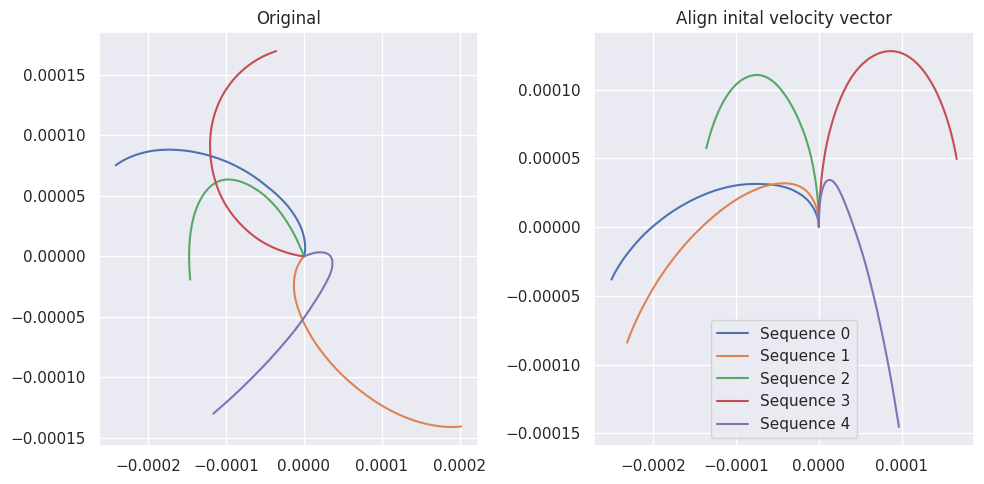

In [50]:
import seaborn as sns
%matplotlib inline
plt.figure()

sns.set_theme()

f, ax = plt.subplots(1, 2)
f.set_figheight(5)
f.set_figwidth(10)
# plt.xlabel(r'$x$')
# plt.ylabel(r'$y$')
for i, (sequence, rotated, rotated_all, pos, rot_pos, avg_vel) in enumerate(bubble_sequences):
    # # print(pos)
    ax[0].plot(pos[:,0]-pos[0, 0], pos[:, 1]-pos[0, 1], label=f'Sequence {i}')
    # # print(pos)
    # # print(pos, rot_pos)
    ax[1].plot(rot_pos[:,0]-rot_pos[0, 0], rot_pos[:, 1]-rot_pos[0, 1], label=f'Sequence {i}')
    # print(rotated_all[:, 0])
    # print(pos)
    # plt.plot(avg_vel[:, 0])
    # plt.plot(seq
    # uence[:, 0])
    # plt.plot(rotated[:, 0])
    # plt.plot(rotated[:, 0])

    # plt.plot(rotated[:,0])

    # plt.scatter(sequence[0,0], sequence[0,1], label='og')
    # plt.scatter(rotated[0,0], rotated[0,1], label='rot')


# plt.xlim(-0.0005, 0.0002)

# plt.ylim(-0.0002, 0.0005)
ax[0].set_title('Original')
ax[1].set_title('Align inital velocity vector')

plt.tight_layout()
plt.legend()
plt.show()
# plt.ylim(-1*10**-6, 1*10**-6)


3


<Figure size 640x480 with 0 Axes>

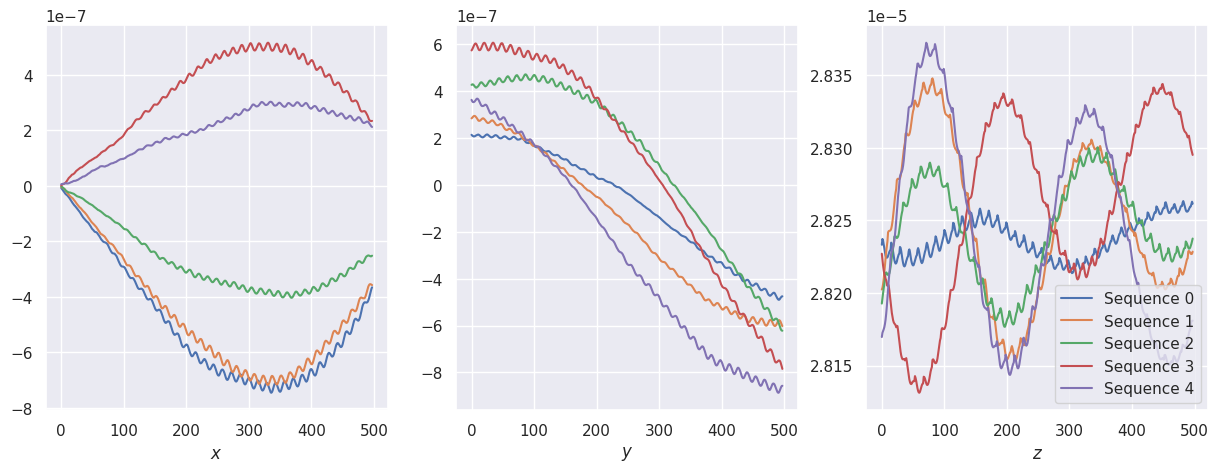

In [56]:
import seaborn as sns
%matplotlib inline
plt.figure()

sns.set_theme()

f, ax = plt.subplots(1, 3)

f.set_figheight(5)
f.set_figwidth(15)
print(len(ax))
for j, (sequence, rotated, rotated_all, pos, rot_pos, avg_vel) in enumerate(bubble_sequences):
    # # print(pos)
    # plt.plot(pos[:,0]-pos[0, 0], pos[:, 1]-pos[0, 1], label='Original')
    # # print(pos)
    # # print(pos, rot_pos)
    # plt.plot(rot_pos[:,0]-rot_pos[0, 0], rot_pos[:, 1]-rot_pos[0, 1], label='Rotated 45°')
    # print(rotated_all[:, 0])
    # print(pos)
    # plt.plot(avg_vel[:, 0])
    # plt.plot(seq
    # uence[:, 0])

    for i in range(3):
        ax[i].plot(rotated_all[:, i], label=f'Sequence {j}')
        # ax[i].plot(rotated[:, i],  label='Rotated 45°')

        
    # plt.plot(rotated[:,0])

    # plt.scatter(sequence[0,0], sequence[0,1], label='og')
    # plt.scatter(rotated[0,0], rotated[0,1], label='rot')
# plt.xlabel(r'$x$')
# plt.ylabel(r'$y$')
# plt.xlim(-0.0005, 0.0002)

# plt.ylim(-0.0002, 0.0005)

ax[0].set_xlabel(r'$x$')
ax[1].set_xlabel(r'$y$')
ax[2].set_xlabel(r'$z$')

plt.legend()
plt.show()
# plt.ylim(-1*10**-6, 1*10**-6)


1
False
[-7.84482299e-08  4.64155553e-07  2.83203941e-05] [-7.84482299e-08  4.64155553e-07  2.83203941e-05] [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
tensor([-7.8448e-08,  4.6416e-07,  2.8320e-05])
False
[-7.84482299e-08  4.64155553e-07  2.83203941e-05] [2.25731004e-14 4.70738252e-07 2.83203941e-05] [[ 0.98601621 -0.16664941  0.        ]
 [ 0.16664941  0.98601621  0.        ]
 [ 0.          0.          1.        ]]
tensor([2.2573e-14, 4.7074e-07, 2.8320e-05])
False
[-8.18641582e-08  4.69643830e-07  2.83141084e-05] [-8.83369276e-10  4.76724540e-07  2.83141084e-05] [[ 0.98546198 -0.16989608  0.        ]
 [ 0.16989608  0.98546198  0.        ]
 [ 0.          0.          1.        ]]
tensor([-8.8337e-10,  4.7672e-07,  2.8314e-05])
False
[-8.35467906e-08  4.76222009e-07  2.83132540e-05] [-2.20149842e-10  4.83495005e-07  2.83132540e-05] [[ 0.98503593 -0.17234911  0.        ]
 [ 0.17234911  0.98503593  0.        ]
 [ 0.          0.          1.        ]]
tensor([-2.2015e-10,  4.8350e-07,  2.8313e-05

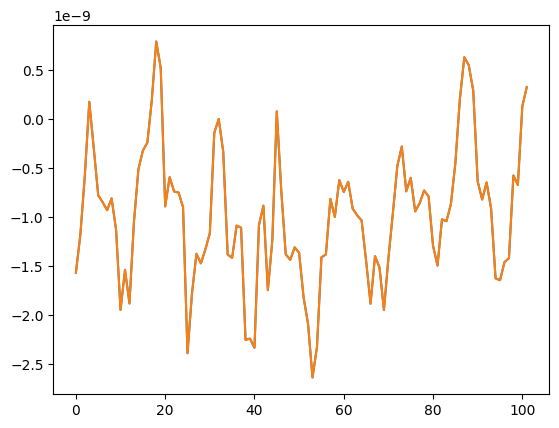

In [22]:
from experimental.remesh.sequence_dataset import BubbleSequenceDataset

for bubble_id in [2, 5]:
    dataset = BubbleSequenceDataset(
        './bubble-data',
        # transforms=[RelativeNoiseTransform(args.noise)]
        # if args.noise is not None
        # else None,
        remesh_velocity=False,
        target_acceleration=True,
        center_prediction = True,
        # ignore_sequences=[1, 2,3,4,5,6,7,8]
        start_point=bubble_id
    )

    sequence = dataset[0]

    rotation_matrix_groundtruth = rotation_matrix_to_y_axis(sequence[0].center_velocity)
    sequence.set_rotation_matrix(rotation_matrix_groundtruth)


    center_vels = []

    for (count, bubble) in enumerate(sequence):
        center_vels.append(bubble.center_target)
        rotation_matrix_groundtruth = rotation_matrix_to_y_axis(center_vels[-1])@rotation_matrix_groundtruth
        sequence.set_rotation_matrix(rotation_matrix_groundtruth)

        if count > 100:
            break
    center_vels = np.array(center_vels)


    plt.plot(center_vels[:, 0])


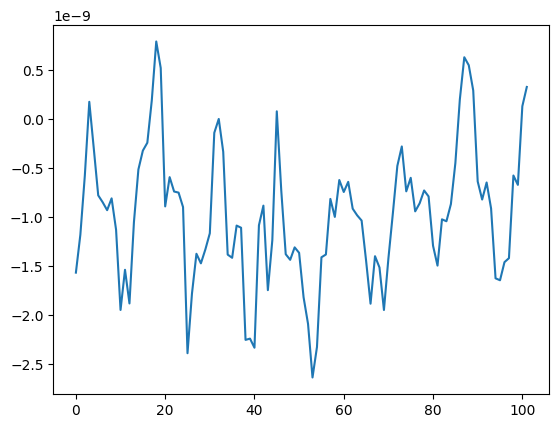

In [21]:

# plt.show()

# center_vels

In [4]:
# %memit

bubble_sequences2 = []
from loky import get_reusable_executor


executor = get_reusable_executor(max_workers=1, timeout=2)

sequence_n = [ 2,3,4,5,6]

sequence_n = [2, 5]

for bubble_n in sequence_n:
    print(bubble_n)
    # %memit

    start_id = bubble_n*8000
    end_id = start_id+30

    def say_hello(k):
        # print('start')
        dataset = BubbleSequence(
        './bubble-data',
        bubble_n,
        remesh_velocity=True,
        target_acceleration=False,
        center_prediction=True
        )

        # print(dataset[i].center_velocity)
        # print(rotation_matrix)

        sequence = []
        velocities = []
        positions = []
        positions_rot = []

        mats = []

        # # for bubble_id in range(start_id, end_id):


        vel = dataset[0].center_velocity
        for bubble_id in range(0, 100):
            dataset.set_rotation_matrix(np.diag([1.0, 1.0, 1.0]))
            vel = dataset[bubble_id ].center_velocity


            # dataset[bubble_id].center_velocity
            # rotation_matrix = rotation_matrix_to_y_axis(np.mean([dataset[bubble_id].center_velocity for i in range(1)], axis=0))

            bubble = dataset[bubble_id]
            rotation_matrix = rotation_matrix_to_y_axis(vel)

            mats.append(rotation_matrix)

            # if bubble_id == 1:
            #     print(dataset[bubble_id].center_velocity)
            matrix = mats[0]
            # print(mats)
            for mat in mats[1:]:
                matrix = matrix@mat

            # print(matrix, rotation_matrix)
            # print('here')
            # print(bubble.center_velocity)
            # print(matrix.T)


            # print('here2', bubble.center_velocity@matrix.T)
            dataset.set_rotation_matrix(rotation_matrix)
            # print(bubble_id)
            bubble = dataset[bubble_id]


            # print(bubble.center_velocity)
            # # print(bubble.centroid())
            # print()


            positions.append(bubble.centroid())
            positions_rot.append(bubble.centroid(True))
            velocities.append(dataset[bubble_id+1].center_velocity)
            # sequence.append([bubble.center_target,  , bubble.centroid(True)]) 

        return np.array([velocities, positions, positions_rot])
        print(end_id)

        return get_bubble_info(np.array([dataset[bubble_id] for bubble_id in range(0, 100)]))
    # bubble_sequence = 
    # %memit
    print('test')
    res = executor.submit(say_hello, 8)
    
    # print(res.result())
    bubble_sequences2.append(res.result())



2
test
True
[9.57701170e-08 1.95859334e-07 2.82941650e-05] [9.57701170e-08 1.95859334e-07 2.82941650e-05] [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
tensor([9.5770e-08, 1.9586e-07, 2.8294e-05])
True
[9.57701170e-08 1.95859334e-07 2.82941650e-05] [9.57701170e-08 1.95859334e-07 2.82941650e-05] [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
tensor([9.5770e-08, 1.9586e-07, 2.8294e-05])
True
[9.57701170e-08 1.95859334e-07 2.82941650e-05] [9.57701170e-08 1.95859334e-07 2.82941650e-05] [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
tensor([9.5770e-08, 1.9586e-07, 2.8294e-05])
True
[9.57701170e-08 1.95859334e-07 2.82941650e-05] [1.67613805e-14 2.18020169e-07 2.82941650e-05] [[ 0.89835423  0.43927175  0.        ]
 [-0.43927175  0.89835423  0.        ]
 [ 0.          0.          1.        ]]
tensor([1.6761e-14, 2.1802e-07, 2.8294e-05])
True
[9.41195795e-08 1.92969981e-07 2.82950661e-05] [-2.13539212e-10  2.14699472e-07  2.82950661e-05] [[ 0.89835423  0.43927175  0.        ]
 [-0.43927175  0.89835423  0.        ]
 [ 0.   

KeyboardInterrupt: 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


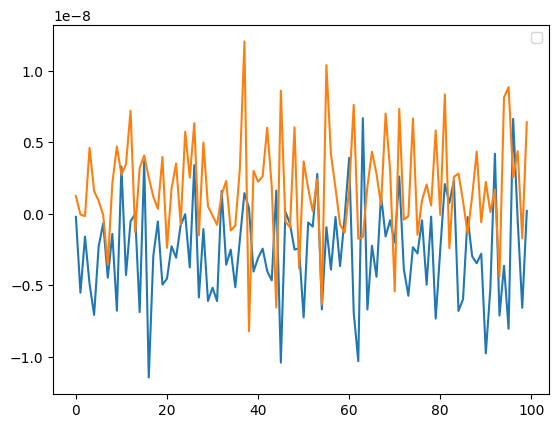

In [26]:
for velocities, rot_pos, pos in bubble_sequences2:
    # print(pos)
    # print(rot_pos)
    # plt.plot(pos[:,0]-pos[0, 0], pos[:, 1]-pos[0, 1], label='og')

    # # print(pos, rot_pos)
    # plt.plot(rot_pos[:,0]-rot_pos[0, 0], rot_pos[:, 1]-rot_pos[0, 1], label='rot')

    plt.plot(velocities[:,0])
    # plt.plot(velocities[:,0])
plt.legend()
# plt.ylim(-1*10**-6, 1*10**-6)

# plt.xlim(-1*10**-6, 1*10**-6)    

In [ ]:
from copy import deepcopy

sequence= bubble_sequences[0]


start_bubble = deepcopy(sequence[0])

print(start_bubble.positions.shape, start_bubble.labels["target"].shape)
        # bubble.update(delta, True, center_out/center_normalizer)
positions = []
positions2 = []

for i in range(0, 200):
#     print(i,start_bubble.positions.shape, sequence[i].labels["target"].shape)
    # print(sequence[i].center_target)
    print(sequence[i].labels["target"].shape)
    start_bubble.update(sequence[i].labels["target"], False, sequence[i].center_target)

    start_bubble.remesh(sequence[i].instructions)

    positions.append(start_bubble.centroid())
    positions2.append(sequence[i].centroid())


: 

: 

In [1]:
%matplotlib widget
positions = np.array(positions)
positions2 = np.array(positions2)
plt.figure()


# plt.plot(positions2[:10, 0], positions2[:10, 1])

NameError: name 'np' is not defined

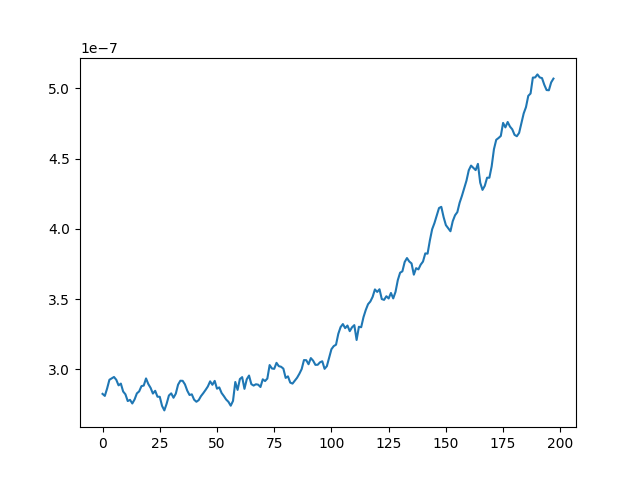

In [71]:
plt.figure()
plt.plot(rotated_vels[:, 1])
plt.show()

In [16]:
bubble_velocities

array([[ 7.49230026e-05,  4.44210242e-05,  2.82251618e-05],
       [-8.01355156e-05, -4.67576665e-05,  2.82275159e-05],
       [-1.36387572e-04, -8.14766999e-05,  2.82265796e-05],
       [ 2.57194666e-05,  1.59500403e-05,  2.82300982e-05],
       [-1.59429721e-04, -9.75036943e-05,  2.82344913e-05],
       [ 1.55390016e-04,  9.57670332e-05,  2.82413792e-05],
       [-1.23710882e-04, -7.53832150e-05,  2.82402774e-05],
       [ 3.46613611e-05,  2.17492411e-05,  2.82409389e-05],
       [-2.67493943e-04, -1.68337319e-04,  2.82475079e-05],
       [ 3.00490119e-04,  1.89285837e-04,  2.82537901e-05],
       [-2.91061973e-04, -1.82468036e-04,  2.82596345e-05],
       [ 2.49701173e-04,  1.57812663e-04,  2.82572651e-05],
       [-5.51064641e-05, -3.37560918e-05,  2.82620959e-05],
       [ 7.83017924e-05,  4.87462943e-05,  2.82656838e-05],
       [-2.68266661e-05, -1.61359999e-05,  2.82743355e-05],
       [ 1.18806959e-04,  7.27898117e-05,  2.82755323e-05],
       [-2.20274639e-04, -1.35233059e-04

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


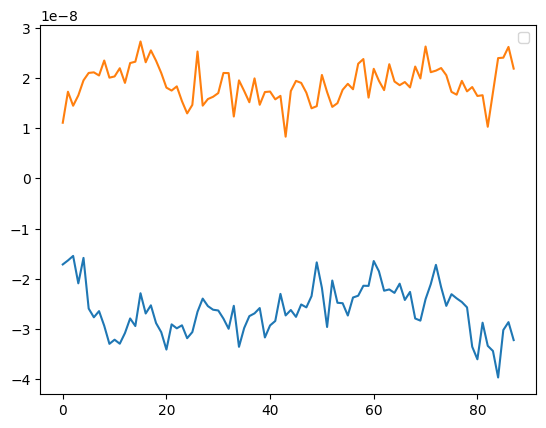

In [125]:
for i in range(0, len(bubble_sequences)):
    # bubble_velocities, rotated_velocities = get_bubble_info(bubble_sequences[i])
    bubble_velocities, rotated_velocities, rotated_all_velocities, _, _ = bubble_sequences[i]
    # smoothed_velocities = running_average_columns(bubble_velocities, 50)
    plt.plot(rotated_all_velocities[:, 0])
    # plt.plot(rotated_velocities[:, 0], label='rotated')
    # plt.plot(bubble_velocities[:, 0], label='normal')
    # plt.plot(rotated_all_velocities[:, 0], bubble_velocities[:,1], label=f'{sequence_n[i]} rotated')
    # plt.plot(bubble_velocities[:, 0], bubble_velocities[:,1], label=f'{i} normal')
    plt.legend()

In [46]:
smoothed_velocities

array([[5.06241697e-08, 5.06241697e-08],
       [4.95513507e-08, 4.95513507e-08],
       [4.83049473e-08, 4.83049473e-08],
       ...,
       [1.55338873e-06, 1.55338873e-06],
       [1.55398279e-06, 1.55398279e-06],
       [1.55390361e-06, 1.55390361e-06]])

In [43]:
rotated_velocities

array([[ 8.96948076e-24,  1.04001377e-07],
       [-6.23770963e-09,  1.04733011e-07],
       [-1.90049535e-09,  9.67119210e-08],
       ...,
       [ 6.75206908e-07,  2.43307535e-06],
       [ 6.72605662e-07,  2.43268240e-06],
       [ 6.75166246e-07,  2.43516015e-06]])

In [17]:
def running_average_3d(arr, window_size):
    shape = arr.shape
    averages = np.zeros(shape)

    for i in range(shape[0]):
        for j in range(shape[1]):
            for k in range(shape[2]):
                window = arr[max(i-window_size//2, 0):min(i+window_size//2+1, shape[0]),
                             max(j-window_size//2, 0):min(j+window_size//2+1, shape[1]),
                             max(k-window_size//2, 0):min(k+window_size//2+1, shape[2])]
                averages[i, j, k] = np.mean(window)

    return averages


def running_average_2d(arr, window_size):
    shape = arr.shape
    averages = np.zeros(shape)

    for i in range(shape[0]):
        for j in range(shape[1]):
            window = arr[max(i-window_size//2, 0):min(i+window_size//2+1, shape[0]),
                         max(j-window_size//2, 0):min(j+window_size//2+1, shape[1])]
            averages[i, j] = np.mean(window)

    return averages

In [18]:

def running_average_columns(arr, window_size):
    shape = arr.shape
    averages = np.zeros(shape)

    for j in range(shape[1]):
        for i in range(shape[0]):
            window = arr[max(i-window_size//2, 0):min(i+window_size//2+1, shape[0]), j]
            averages[i, j] = np.mean(window)

    return averages

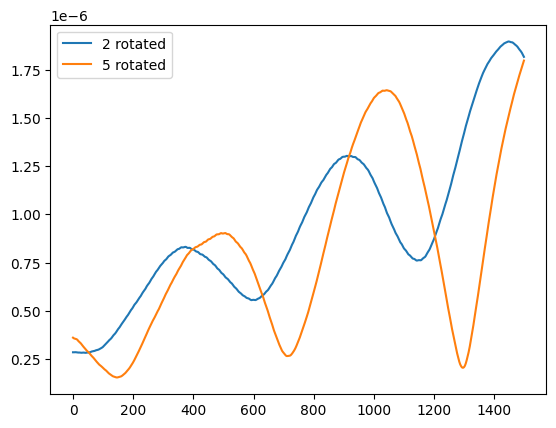

In [35]:
# for i in range(0, len(bubble_sequences)):
%matplotlib inline

window_size = 30
from scipy.ndimage import convolve
for i in range(len(bubble_sequences)):

    # bubble_velocities, rotated_velocities = get_bubble_info(bubble_sequences[i])
    bubble_velocities, rotated_velocities, rotated_all_velocities = bubble_sequences[i]
    
    smoothed_velocities = running_average_columns(bubble_velocities, window_size)
    rotated_all_velocities1 = np.array([rotate_by_step(smoothed_velocities[i-1], bubble_velocity) for i, bubble_velocity in enumerate(smoothed_velocities) if i > 0])
    # print(rotated_velocities[:, 0])
    plt.plot(rotated_all_velocities1[:1500, 1], label=f'{sequence_n[i]} rotated', alpha=1)
    # plt.plot(bubble_velocities[:, 0], label=f'{i} normal')
    # plt.plot(rotated_velocities[:, 0], rotated_velocities[:,1], label='rotated')
    # plt.plot(bubble_velocities[:, 0], bubble_velocities[:,1], label='normal')
    # plt.plot(smoothed_velocities[:, 0], smoothed_velocities[:,1], label=f'{sequence_n[i]} rotated')

    plt.legend()
plt.show()

In [21]:
rotated_all_velocities

array([[ 7.73746169e-10, -5.38188546e-09],
       [-5.11331181e-09,  4.66080261e-09],
       [-2.33351722e-09, -1.48253840e-09],
       ...,
       [-6.54633976e-09,  2.90219474e-09],
       [-6.86303573e-09,  4.43377913e-10],
       [-4.10454725e-09,  5.06954427e-09]])